# Classification: Autoencoder (also Deep Learning)

In diesem Notebook verwenden wir Neuronale Netze um die Klassifizierung in "Failure"/"No Failure " durchzuführen.

In [1]:
#mount data
from google.colab import drive
drive.mount('/content/drive')
datapath = "/content/drive/My Drive/smartdata/2/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import sys
sys.path.append(datapath)

In [5]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

epochs = 150

# Load data
train, test = pd.read_csv(datapath+"resampled/resampled_3H_mean.csv"), pd.read_csv(datapath+"resampled_test/resampled_3H_mean.csv")
drift = ['pitch motor 1 current', 'pitch motor 2 current', 'Pitch motor 3 current', 'x direction vibration value', 'y direction vibration value', 'hydraulic brake pressure', 'generator current', 'Inverter inlet temperature', 'inverter outlet temperature', 'inverter inlet pressure', 'inverter outlet pressure', 'wind tower ambient temperature', 'Wheel temperature', 'Wheel control cabinet temperature', 'Cabin temperature', 'Cabin control cabinet temperature', 'vane 1 pitch motor temperature', 'blade 2 pitch motor temperature', 'blade 3 pitch motor temperature', 'blade 1 inverter box temperature', 'blade 2 inverter box temperature', 'blade 3 inverter box temperature','inverter grid side current', 'Inverter grid side active power', 'inverter generator side power', 'generator operating frequency','generator stator temperature 1', 'generator stator temperature 2',  'generator stator temperature 3', 'generator stator temperature 4', 'Generator stator temperature 5', 'generator stator temperature 6', 'generator air temperature 1', 'generator air temperature 2','main bearing temperature 1', 'main bearing temperature 2', 'Pitch motor 1 power estimation', 'Pitch motor 2 power estimation', 'Pitch motor 3 power estimation', 'blade 1 battery box temperature', 'blade 2 battery box temperature', 'blade 3 battery box temperature','Inverter INU temperature', 'Inverter ISU temperature','atmospheric pressure', 'reactive power control status', 'reactive power set value', 'Inverter INU RMIO temperature','blade 1 angle','blade 2 angle','blade 3 angle','inverter grid side voltage','inverter grid side reactive power']

train.drop(drift, axis = 1, inplace=True)
train.drop("Unnamed: 0", axis = 1, inplace=True)
train.drop("area", axis = 1, inplace=True)

test.drop(drift, axis = 1, inplace=True)
test.drop("Unnamed: 0", axis = 1, inplace=True)
test.drop("area", axis = 1, inplace=True)

In [6]:
from sklearn import preprocessing
#scale between 0 and 1
min_max_scaler = preprocessing.MinMaxScaler()

train[train.columns] = min_max_scaler.fit_transform(train[train.columns])
test[test.columns]  = min_max_scaler.fit_transform(test[test.columns])

In [54]:
#normal data (OK)
normal_data_train = train[train["label"] == 0].drop("label", axis = 1).reset_index(drop=True)
normal_data_test = test[test["label"] == 0].drop("label", axis = 1).reset_index(drop=True)
#anomaly data (not OK)
anomaly_data = train[train["label"] == 1]
anomaly_data = pd.concat([anomaly_data, test[test["label"] == 1]]).drop("label", axis = 1).reset_index(drop=True)

In [31]:
# define the keras autoencoder model
from keras.optimizers import Adam
model = Sequential()

model.add(Dense(11, input_dim = 22, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='tanh'))
model.add(Dense(6, activation='tanh'))
model.add(Dense(11, activation='tanh'))
# sigmoid to get output data in [0,1]
model.add(Dense(22, activation='sigmoid'))

# compile the keras model
model.compile(loss='mse', optimizer=Adam(), metrics=['accuracy','mse'])

# fit the keras model on the dataset
history = model.fit(normal_data_train, normal_data_train, epochs=epochs, batch_size=1024, verbose=1, validation_data=(normal_data_test, normal_data_test))

Epoch 1/150
397/397 [==============================] - 3s 5ms/step - loss: 0.0983 - accuracy: 0.1679 - mse: 0.0983 - val_loss: 0.0470 - val_accuracy: 0.5102 - val_mse: 0.0470
Epoch 2/150
397/397 [==============================] - 1s 4ms/step - loss: 0.0287 - accuracy: 0.3495 - mse: 0.0287 - val_loss: 0.0419 - val_accuracy: 0.5102 - val_mse: 0.0419
Epoch 3/150
397/397 [==============================] - 1s 4ms/step - loss: 0.0208 - accuracy: 0.3521 - mse: 0.0208 - val_loss: 0.0422 - val_accuracy: 0.5102 - val_mse: 0.0422
Epoch 4/150
397/397 [==============================] - 2s 4ms/step - loss: 0.0183 - accuracy: 0.3516 - mse: 0.0183 - val_loss: 0.0416 - val_accuracy: 0.5102 - val_mse: 0.0416
Epoch 5/150
397/397 [==============================] - 1s 4ms/step - loss: 0.0160 - accuracy: 0.3470 - mse: 0.0160 - val_loss: 0.0423 - val_accuracy: 0.5087 - val_mse: 0.0423
Epoch 6/150
397/397 [==============================] - 2s 4ms/step - loss: 0.0145 - accuracy: 0.3508 - mse: 0.0145 - val_loss

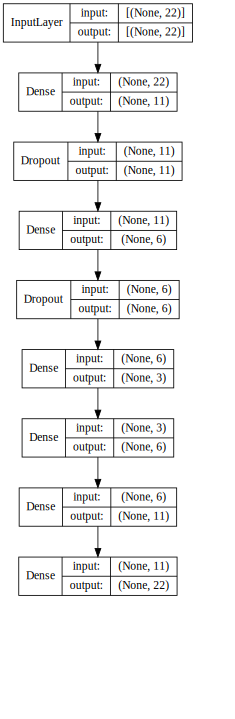

In [32]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model,show_shapes=True, show_layer_names=False, dpi=60).create(prog='dot', format='svg'))

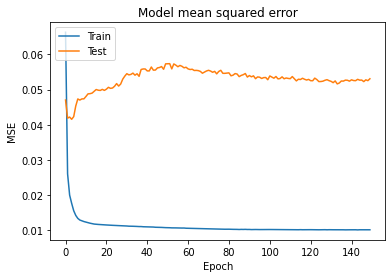

In [35]:
import matplotlib.pyplot as plt
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Model mean squared error')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train','Test'], loc='upper left')
plt.show()

In [37]:
# predict normal data (test data) and anomalies (failure data)
predicted_normal = model.predict(normal_data_test)
predicted_anomaly = model.predict(anomaly_data)

In [38]:
import math
import statistics
def error(input,output):
    return np.mean(np.square(input-output))

In [ ]:
import numpy as np

# calculate error and plot errors based on samples
error_normal = np.array([error(normal_data_test.iloc[i],predicted_normal[i]) for i in range(0,len(normal_data_test))])
error_anomaly = np.array([error(anomaly_data.iloc[i],predicted_anomaly[i]) for i in range(0,len(anomaly_data))])
error_all = np.concatenate((error_normal,error_anomaly))

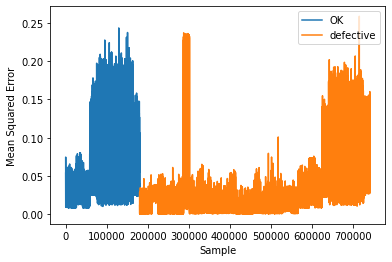

In [78]:
plt.plot(error_normal)
plt.plot(range(len(error_normal),len(error_normal)+len(error_anomaly)), error_anomaly)
plt.ylabel('Mean Squared Error')
plt.xlabel('Sample')
plt.legend(["OK","defective"], loc='upper right')
plt.show()